# Exercise 11

* In the lecture, we trained an FNO on the 16x16 Darcy flow dataset.

* Download the 32x32 Darcy flow dataset from here: https://zenodo.org/records/12784353

* Evaluate our trained model on the higher resolution dataset (i.e. do zero-shot super-resolution). How does it perform?

## Solution
* **N.B. unfortunately the original Zenodo link we gave you was to v1 of the data, which had an error in the 32x32 dataset. The above link is to v2 of the data, in which the 32x32 dataset has been fixed.**

* First let's just copy over the code from the lecture to set up and train the neural operator.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add(
    [
    "Flux",
    "Zygote",
    "Optimisers",
    "FFTW",
    "NNlib",
    "MLUtils",
    "ChainRulesCore",
    "CUDA",
    "cuDNN",
    "ParameterSchedulers",
    "Statistics",
    "Printf",
    "PyCall",
    "Plots",
    ]
) # Ignore circular dependency warning!

  Activating project at `/p/tmp/alistair/TUM-Dynamics-Lecture/exercises/exercise-14`
   Resolving package versions...
  No Changes to `/p/tmp/alistair/TUM-Dynamics-Lecture/exercises/exercise-14/Project.toml`
  No Changes to `/p/tmp/alistair/TUM-Dynamics-Lecture/exercises/exercise-14/Manifest.toml`
┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   ChainRules [082447d4-558c-5d27-93f4-14fc19e9eca2]
│   SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]
│   GPUArrays [0c68f7d7-f131-5f86-a1c3-88cf8149b2d7]
│   FluxCUDAcuDNNExt [a1ab010e-6f71-51d6-acc8-fb8bfa4c0f92]
│   KernelAbstractions [63c18a36-062a-441e-b654-da1e3ab1ce7c]
│   FluxCUDAExt [dd41ee52-2073-581e-92e8-26baf003f19a]
│   OneHotArrays [0b1bfda6-eb8a-41d2-88d8-f5af5cad476f]
│   MLDataDevicesOneHotArraysExt [338a49bd-c049-5b4c-976b-5ff9d2bfb7e7]
│   MLDataDevicesGPUArraysExt [b7a43d79-68b1-555e-8052-5fba48570bb1]
│   cuDNN [02a925ec-e4fe-4b08-9a7e-0d78e3d38ccd]
│   NNlibEnzymeCoreExt [c8a29c4

In [2]:
using Flux, Zygote, FFTW, ChainRulesCore, CUDA, ParameterSchedulers, Printf, Statistics, Plots

### Spectral Convolution Layer

In [3]:
"""
    SpectralConv{T,N,W}
Spectral convolution layer for Fourier Neural Operator implementation in Flux.jl.
Expects input in (spatial..., channel, batch) format.
"""
struct SpectralConv{T,N,W<:AbstractArray{T}}
    weight::W
    modes::NTuple{N,Int}
end

# Constructor
function SpectralConv(in_channels::Integer, out_channels::Integer, modes::NTuple{N,Integer}) where N
    init_std = sqrt(2f0 / (in_channels + out_channels))  # Standard Glorot-like scaling
    weight = init_std * randn(ComplexF32, modes..., out_channels, in_channels)
    return SpectralConv{ComplexF32,N,typeof(weight)}(weight, modes)
end

# Convenience constructor using Pair syntax
SpectralConv(ch::Pair{<:Integer,<:Integer}, modes::NTuple{N,Integer}) where N = SpectralConv(first(ch), last(ch), modes)

"""
    low_pass(x_ft, modes)

Apply a low-pass filter to a Fourier-transformed array by retaining only the lowest frequency modes.

# Arguments
- `x_ft`: A Fourier-transformed array with at least 2 trailing dimensions
- `modes`: A tuple or array specifying the number of low-frequency modes to keep along each leading dimension

# Returns
- A view of the input array `x_ft` containing only the specified low-frequency modes, preserving the last two dimensions in full

# Details
The function creates a view that selects the first `modes[i]` elements along each leading dimension `i`,
while keeping all elements of the last two dimensions. This effectively implements a low-pass filter
in Fourier space by truncating high-frequency modes.
"""
function low_pass(x_ft, modes)
    return view(x_ft, map(d -> 1:d, modes)..., :, :)
end

"""
    apply_pattern(x_tr::AbstractArray{T,N}, weights::AbstractArray{T,3}) where {T,N}

Apply learned weight patterns to truncated Fourier coefficients.

# Arguments
- `x_tr::AbstractArray{T,N}`: Truncated Fourier coefficients after low-pass filtering, with shape (modes..., in_channels, batch)
- `weights::AbstractArray{T,4}`: Complex-valued learned weights with shape (modes..., out_channels, in_channels)

# Returns
- Weighted Fourier coefficients with shape (modes..., out_channels, batch)
"""
function apply_pattern(x_tr::AbstractArray{T,N}, weights::AbstractArray{T}) where {T,N}
    # Insert new axis for out_channels before batch dimension
    # x_tr: (mode1, mode2, in_channels, batch)
    x_expanded = reshape(x_tr, size(x_tr)[1:N-2]..., 1, size(x_tr)[N-1:N]...)
    
    # Now shapes will be:
    # x_expanded: (mode1, mode2, 1, in_channels, batch)
    # weights:    (mode1, mode2, out_channels, in_channels)
    
    # Contract over in_channels dimension
    return dropdims(sum(weights .* x_expanded, dims=N), dims=N)  # (mode1, mode2, out_channels)
end

"""
    expand_pad_dims(pad_dims::Dims{N}) where {N}

Convert N-dimensional padding specification into format required for NNlib's pad_constant function.

# Arguments
- `pad_dims::Dims{N}`: Tuple of N integers specifying the total padding needed along each dimension

# Returns
- `NTuple{2N,Int}`: Tuple of 2N integers specifying padding for both sides of each dimension,
  where padding is applied only at the end of each dimension (start padding is always 0)
"""
function expand_pad_dims(pad_dims::Dims{N}) where {N}
    return ntuple(i -> isodd(i) ? 0 : pad_dims[i ÷ 2], 2N)
end
@non_differentiable expand_pad_dims(::Any)

# Main forward pass
function (layer::SpectralConv)(x)
    # Apply Fourier transform on the spatial dimensions
    x_ft = fft(x, 1:ndims(x)-2)  # Last two dims are channel and batch, only FFT on spatial dims
    
    # Truncate modes and apply weights
    x_tr = low_pass(x_ft, layer.modes)
    x_p = apply_pattern(x_tr, layer.weight)
    
    # Pad the result back to original size
    pad_dims = size(x_ft)[1:(end - 2)] .- size(x_p)[1:(end - 2)]
    x_padded = NNlib.pad_constant(x_p, expand_pad_dims(pad_dims), false; dims=ntuple(identity, ndims(x_p) - 2))
    
    # Inverse Fourier transform
    return real(ifft(x_padded, 1:ndims(x_padded)-2))
end

# Make the layer compatible with Flux's training
Flux.@layer SpectralConv

### Spectral Kernel Layer

In [4]:
"""
    SpectralKernel{P,F}

Combines a SpectralConv layer with a 1x1 convolution in parallel, followed by an activation function.
Expects input in (spatial..., channel, batch) format.
"""
struct SpectralKernel{P,F}
    parallel::P    # Parallel(+, spatial_conv, spectral_conv)
    activation::F  # Activation function
end

# Constructor
function SpectralKernel(ch::Pair{<:Integer,<:Integer}, modes::NTuple{N,Integer}, activation=gelu) where N
    in_ch, out_ch = ch

    # local
    # Create 1x1 convolution with kernel size 1
    conv = Conv((1,1), in_ch => out_ch, pad = 0)

    # global
    # Create spectral convolution
    spectral = SpectralConv(ch, modes)
    
    # Combine using Parallel
    parallel = Parallel(+, conv, spectral)
    
    return SpectralKernel(parallel, activation)
end

# Forward pass
function (layer::SpectralKernel)(x::AbstractArray)
    layer.activation.(layer.parallel(x))
end

# Make the layer compatible with Flux's training
Flux.@layer SpectralKernel

### Soft Gating Layer

In [5]:
# Soft gating layer implementation
struct SoftGating
    channels::Int
    weights::AbstractArray  # shouldn't have abstract type annotations!
end

# Constructor for SoftGating
function SoftGating(channels::Int)
    weights = ones(Float32, 1, 1, channels, 1)  # initially let all channels pass through
    return SoftGating(channels, weights)
end

# Forward pass for SoftGating
function (sg::SoftGating)(x)
    return sg.weights .* x
end

Flux.@layer SoftGating trainable=(weights,)

### Channel MLP Layer

In [6]:
# Parallel layer for combining channel MLP and skip connection
struct ChannelMLP{M,S}
    mlp::M
    skip::S
end

# Forward pass for ChannelMLP
function (p::ChannelMLP)(x)
    return p.mlp(x) + p.skip(x)
end

# Main ChannelMLP constructor
function ChannelMLP(channels::Int; expansion_factor=0.5, activation=gelu)
    mlp = Chain(
        Conv((1, 1), channels => Int(expansion_factor * channels), activation),
        Conv((1, 1), Int(expansion_factor * channels) => channels)
    )
    
    return ChannelMLP(
        mlp,
        SoftGating(channels),
    )
end

# Make the layers compatible with Flux's training utilities
Flux.@layer ChannelMLP trainable=(mlp, skip)

### Positional Embedding Layer

In [7]:
# Positional embedding
# make this more efficient!
function meshgrid(x, y)
  return (repeat(x, 1, length(y)), repeat(y', length(x), 1))
end

struct GridEmbedding2D
  boundaries_x::Vector{Float32}
  boundaries_y::Vector{Float32}
end

function GridEmbedding2D(grid_boundaries=[[0f0, 1f0], [0f0, 1f0]])
  return GridEmbedding2D(grid_boundaries[1], grid_boundaries[2])
end

ChainRulesCore.@non_differentiable LinRange{Float32,Int64}(start::Float32, stop::Float32, length::Int64)

function (ge::GridEmbedding2D)(x)
    height, width, channels, batch_size = size(x)

    x_range = LinRange(ge.boundaries_x..., height)
    y_range = LinRange(ge.boundaries_y..., width)
    grid_x, grid_y = meshgrid(x_range, y_range)
    
    grid_x = reshape(grid_x, (height, width, 1, 1))
    grid_x = repeat(grid_x, outer = (1, 1, 1, batch_size)) |> get_device(x)
    
    grid_y = reshape(grid_y, (height, width, 1, 1))
    grid_y = repeat(grid_y, outer = (1, 1, 1, batch_size)) |> get_device(x)
    
    return cat(x, grid_x, grid_y, dims=length(size(x))-1)
end

@non_differentiable (::GridEmbedding2D)(::Any)

### Fourier Neural Operator

In [8]:
struct FourierNeuralOperator{M}
    model::M
end
Flux.@layer FourierNeuralOperator

# Forward pass for FNO
function (fno::FourierNeuralOperator)(x)
    return fno.model(x)
end

# Use exact same API as Python library
function FourierNeuralOperator(
  ;
  activation=gelu,
  in_channels,
  out_channels,
  hidden_channels=32,
  n_modes=(16, 16),  # Number of modes to keep in frequency domain
  n_layers=4,  # Number of spectral kernel layers
  lifting_channel_ratio=2,
  projection_channel_ratio=2,
  channel_mlp_expansion=0.5,
  positional_embedding="grid",
)
  n_dim = length(n_modes)
  if positional_embedding == "grid"
    embedding = GridEmbedding2D()
    in_channels += n_dim
  end

  lifting = Chain(
      Conv((1, 1), in_channels => Int(lifting_channel_ratio * hidden_channels), activation),
      Conv((1, 1), Int(lifting_channel_ratio * hidden_channels) => hidden_channels, activation),
  )
  fno_blocks = Chain([
      Chain(
          SpectralKernel(hidden_channels => hidden_channels, n_modes, activation),
          ChannelMLP(hidden_channels; expansion_factor=channel_mlp_expansion, activation=activation),
      ) for i in 1:n_layers
  ]...)
  projection = Chain(
      Conv((1, 1), hidden_channels => Int(projection_channel_ratio * hidden_channels), activation),
      Conv((1, 1), Int(projection_channel_ratio * hidden_channels) => out_channels, activation),
  )
  
  return FourierNeuralOperator(Chain(; positional_embedding=embedding, lifting, fno_blocks, projection))
end

FourierNeuralOperator

### Function for plotting predictions

In [9]:
function create_comparison_figure(inputs, ground_truth, predictions)
    inputs = cpu(inputs)
    ground_truth = cpu(ground_truth)
    predictions = cpu(predictions)
    
    n_samples = size(inputs, 4)
    
    # Create subplots array
    plots_array = []
    
    for i in 1:n_samples
        # Input heatmap (black and white)
        p1 = heatmap(
            inputs[:, :, 1, i], 
            c=:greys, 
            aspect_ratio=:equal,
            axis=false, 
            ticks=false,
            colorbar=false,
            title = i == 1 ? "Input x" : "",
        )
        
        # Ground truth heatmap
        p2 = heatmap(
            ground_truth[:, :, 1, i], 
            c=:viridis,
            aspect_ratio=:equal,
            axis=false,
            ticks=false,
            colorbar=false,
            title = i == 1 ? "Ground-truth y" : "",
        )
        
        # Prediction heatmap
        p3 = heatmap(
            predictions[:, :, 1, i], 
            c=:viridis,
            aspect_ratio=:equal,
            axis=false,
            ticks=false,
            colorbar=false,
            title = i == 1 ? "Model prediction y" : "",
        )
        
        # Add row of plots
        push!(plots_array, p1)
        push!(plots_array, p2)
        push!(plots_array, p3)
    end
    
    # Create the combined plot
    fig = plot(
        plots_array..., 
        layout=(n_samples, 3),
        size=(600, 450),
        margin=2Plots.mm,
    )
    
    return fig
end

create_comparison_figure (generic function with 1 method)

### Get the data

In [10]:
using PyCall, MLUtils
torch = pyimport("torch")

PyObject <module 'torch' from '/home/alistair/.local/lib/python3.12/site-packages/torch/__init__.py'>

In [11]:
# helper function
function process_torch_dataset(dataset)
    _permute_and_reshape(arr) = reshape(permutedims(arr, (2, 3, 1)), size(arr, 2), size(arr, 3), 1, size(arr, 1))

    x = _permute_and_reshape(dataset["x"].numpy())
    y = _permute_and_reshape(dataset["y"].numpy())
    
    return x, y
end

process_torch_dataset (generic function with 1 method)

In [12]:
# we load 16x16 and 32x32
darcy_train_16 = torch.load("/p/tmp/alistair/TUM-Dynamics-Lecture/lectures/lecture-14/assets/darcy_train_16.pt", weights_only=true)
x_train_16, y_train_16 = process_torch_dataset(darcy_train_16)

darcy_test_16 = torch.load("/p/tmp/alistair/TUM-Dynamics-Lecture/lectures/lecture-14/assets/darcy_test_16.pt", weights_only=true)
x_test_16, y_test_16 = process_torch_dataset(darcy_test_16)

darcy_train_32 = torch.load("/p/tmp/alistair/TUM-Dynamics-Lecture/lectures/lecture-14/assets/darcy_train_32.pt", weights_only=true)
x_train_32, y_train_32 = process_torch_dataset(darcy_train_32)

darcy_test_32 = torch.load("/p/tmp/alistair/TUM-Dynamics-Lecture/lectures/lecture-14/assets/darcy_test_32.pt", weights_only=true)
x_test_32, y_test_32 = process_torch_dataset(darcy_test_32);

### Train an FNO on the 16x16 dataset

In [13]:
fno = FourierNeuralOperator(
    in_channels=1,
    out_channels=1,
    hidden_channels=32,
    n_modes=(16,16),
    );

In [14]:
data_loader_16 = DataLoader((x_train_16, y_train_16); batchsize=32)

32-element DataLoader(::Tuple{Array{Bool, 4}, Array{Float32, 4}}, batchsize=32)
  with first element:
  (16×16×1×32 Array{Bool, 4}, 16×16×1×32 Array{Float32, 4},)

In [15]:
# Put the model and the data on the GPU
# Use cpu_device if you don't have a GPU, but this will be slower!
device = gpu_device()
fno = device(fno)
dl = device(data_loader_16)

DeviceIterator{CUDADevice{Nothing}, DataLoader{BatchView{Tuple{Array{Bool, 4}, Array{Float32, 4}}, ObsView{Tuple{Array{Bool, 4}, Array{Float32, 4}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Bool, 4}, Array{Float32, 4}}, Random.TaskLocalRNG}}(CUDADevice{Nothing}(nothing), DataLoader(::Tuple{Array{Bool, 4}, Array{Float32, 4}}, batchsize=32))

In [16]:
# Define the mean-squared error loss function
mse(m, x, y) = mean(abs2, m(x) .- y)

mse (generic function with 1 method)

In [17]:
# Define the optimizer and the learning rate schedule
num_epochs = 150
max_lr = 1f-3  # higher than we used in the lecture
opt_state = Flux.setup(AdamW(eta = max_lr, lambda = 1f-4), fno)
scheduler = CosAnneal(1f-3, 0f0, num_epochs, false)

CosAnneal{Float32, Int64}(0.001f0, 0.0f0, 150, false)

In [18]:
for (epoch, learning_rate) in zip(1:num_epochs, scheduler)
    Optimisers.adjust!(opt_state, Float32(learning_rate))  # cast the LR to Float32 because of a bug in the scheduler
    epoch_loss = 0f0
    num_batches = 0
    
    for (i, d) in enumerate(dl)
        (x, y) = d
        loss, gradients = Zygote.withgradient(m -> mse(m, x, y), fno)
        opt, model = Optimisers.update!(opt_state, fno, gradients[1])
        epoch_loss += loss
        num_batches += 1
    end

    avg_epoch_loss = epoch_loss / num_batches
    @printf("Epoch %3d | LR: %.2e | Avg Loss: %.5f\n", epoch, learning_rate, avg_epoch_loss)
end

Epoch   1 | LR: 1.00e-03 | Avg Loss: 0.11763
Epoch   2 | LR: 1.00e-03 | Avg Loss: 0.02601
Epoch   3 | LR: 1.00e-03 | Avg Loss: 0.02014
Epoch   4 | LR: 9.99e-04 | Avg Loss: 0.01670
Epoch   5 | LR: 9.98e-04 | Avg Loss: 0.01314
Epoch   6 | LR: 9.97e-04 | Avg Loss: 0.01056
Epoch   7 | LR: 9.96e-04 | Avg Loss: 0.00888
Epoch   8 | LR: 9.95e-04 | Avg Loss: 0.00786
Epoch   9 | LR: 9.93e-04 | Avg Loss: 0.00734
Epoch  10 | LR: 9.91e-04 | Avg Loss: 0.00674
Epoch  11 | LR: 9.89e-04 | Avg Loss: 0.00601
Epoch  12 | LR: 9.87e-04 | Avg Loss: 0.00548
Epoch  13 | LR: 9.84e-04 | Avg Loss: 0.00505
Epoch  14 | LR: 9.82e-04 | Avg Loss: 0.00464
Epoch  15 | LR: 9.79e-04 | Avg Loss: 0.00425
Epoch  16 | LR: 9.76e-04 | Avg Loss: 0.00389
Epoch  17 | LR: 9.72e-04 | Avg Loss: 0.00356
Epoch  18 | LR: 9.69e-04 | Avg Loss: 0.00327
Epoch  19 | LR: 9.65e-04 | Avg Loss: 0.00305
Epoch  20 | LR: 9.61e-04 | Avg Loss: 0.00293
Epoch  21 | LR: 9.57e-04 | Avg Loss: 0.00299
Epoch  22 | LR: 9.52e-04 | Avg Loss: 0.00314
Epoch  23 

In [19]:
# evaluate the trained model on the 16x16 test set
x_test_16 = device(x_test_16)
pred = fno(x_test_16);

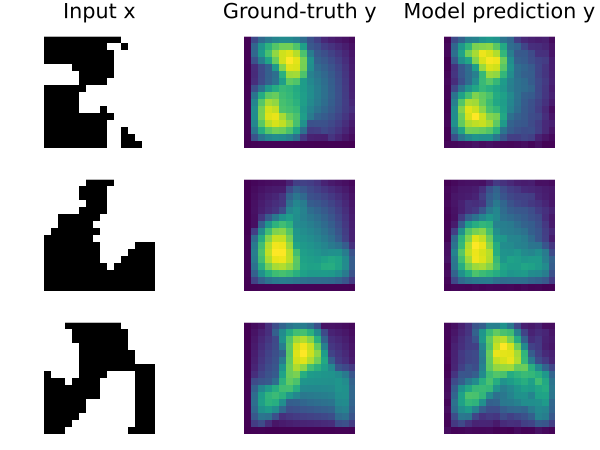

In [20]:
i = 1:3
inputs, ground_truth, predictions = x_test_16[:, :, :, i], y_test_16[:, :, :, i], pred[:, :, :, i]
fig = create_comparison_figure(inputs, ground_truth, predictions)

### Super-resolution

In [21]:
# super-resolution: evaluate the trained model on the 32x32 test set
# remember we only saw 16x16 during training!
x_test_32 = device(x_test_32)
pred = fno(x_test_32);

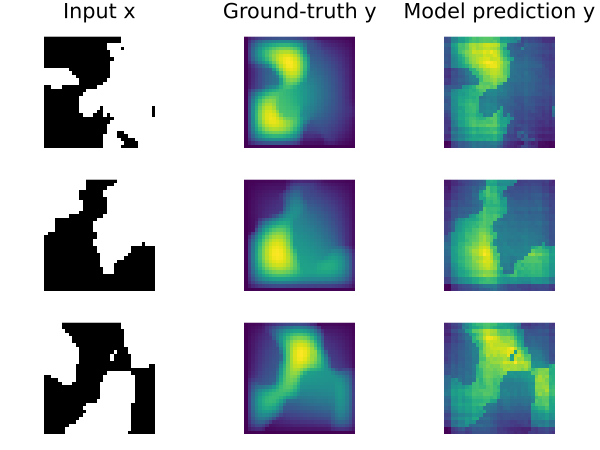

In [22]:
i = 1:3
inputs, ground_truth, predictions = x_test_32[:, :, :, i], y_test_32[:, :, :, i], pred[:, :, :, i]
fig = create_comparison_figure(inputs, ground_truth, predictions)

* While the qualitative shape of the super-resolved prediction looks reasonable, the field is quite rough and patchy.

* However, remember from the lecture that super-resolution is a consequence of the discretization convergence property of neural operators, that is to say, as the grid gets finer ($N \to \infty$), the approximation
$$\int_D \kappa(x,y)v(y)dy \approx \sum_{i=1}^N \kappa(x,y_i)v(y_i)\Delta y_i$$
becomes exact. So perhaps we just haven't reached this regime yet when training on 16x16 data.

* What happens if we train on 32x32 and test on 64x64?

### Train an FNO on the 32x32 dataset
* We'll use the same number of modes but increase the number of hidden channels to give the model more expressive power.

In [23]:
fno = FourierNeuralOperator(
    in_channels=1,
    out_channels=1,
    hidden_channels=64,
    n_modes=(16,16),
    );

In [24]:
data_loader_32 = DataLoader((x_train_32, y_train_32); batchsize=32)

157-element DataLoader(::Tuple{Array{Float32, 4}, Array{Float32, 4}}, batchsize=32)
  with first element:
  (32×32×1×32 Array{Float32, 4}, 32×32×1×32 Array{Float32, 4},)

In [25]:
# Put the model and the data on the GPU
# Use cpu_device if you don't have a GPU, but this will be slower!
device = gpu_device()
fno = device(fno)
dl = device(data_loader_32)

DeviceIterator{CUDADevice{Nothing}, DataLoader{BatchView{Tuple{Array{Float32, 4}, Array{Float32, 4}}, ObsView{Tuple{Array{Float32, 4}, Array{Float32, 4}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Array{Float32, 4}}, Random.TaskLocalRNG}}(CUDADevice{Nothing}(nothing), DataLoader(::Tuple{Array{Float32, 4}, Array{Float32, 4}}, batchsize=32))

In [26]:
# Define the optimizer and the learning rate schedule
num_epochs = 150
max_lr = 1f-3
opt_state = Flux.setup(AdamW(eta = max_lr, lambda = 1f-4), fno)
scheduler = CosAnneal(1f-3, 0f0, num_epochs, false)

CosAnneal{Float32, Int64}(0.001f0, 0.0f0, 150, false)

In [27]:
for (epoch, learning_rate) in zip(1:num_epochs, scheduler)
    Optimisers.adjust!(opt_state, Float32(learning_rate))  # cast the LR to Float32 because of a bug in the scheduler
    epoch_loss = 0f0
    num_batches = 0
    
    for (i, d) in enumerate(dl)
        (x, y) = d
        loss, gradients = Zygote.withgradient(m -> mse(m, x, y), fno)
        opt, model = Optimisers.update!(opt_state, fno, gradients[1])
        epoch_loss += loss
        num_batches += 1
    end

    avg_epoch_loss = epoch_loss / num_batches
    @printf("Epoch %3d | LR: %.2e | Avg Loss: %.5f\n", epoch, learning_rate, avg_epoch_loss)
end

Epoch   1 | LR: 1.00e-03 | Avg Loss: 0.04112
Epoch   2 | LR: 1.00e-03 | Avg Loss: 0.01307
Epoch   3 | LR: 1.00e-03 | Avg Loss: 0.00908
Epoch   4 | LR: 9.99e-04 | Avg Loss: 0.00731
Epoch   5 | LR: 9.98e-04 | Avg Loss: 0.00586
Epoch   6 | LR: 9.97e-04 | Avg Loss: 0.00480
Epoch   7 | LR: 9.96e-04 | Avg Loss: 0.00403
Epoch   8 | LR: 9.95e-04 | Avg Loss: 0.00345
Epoch   9 | LR: 9.93e-04 | Avg Loss: 0.00299
Epoch  10 | LR: 9.91e-04 | Avg Loss: 0.00261
Epoch  11 | LR: 9.89e-04 | Avg Loss: 0.00230
Epoch  12 | LR: 9.87e-04 | Avg Loss: 0.00205
Epoch  13 | LR: 9.84e-04 | Avg Loss: 0.00186
Epoch  14 | LR: 9.82e-04 | Avg Loss: 0.00178
Epoch  15 | LR: 9.79e-04 | Avg Loss: 0.00222
Epoch  16 | LR: 9.76e-04 | Avg Loss: 0.00230
Epoch  17 | LR: 9.72e-04 | Avg Loss: 0.00182
Epoch  18 | LR: 9.69e-04 | Avg Loss: 0.00161
Epoch  19 | LR: 9.65e-04 | Avg Loss: 0.00150
Epoch  20 | LR: 9.61e-04 | Avg Loss: 0.00141
Epoch  21 | LR: 9.57e-04 | Avg Loss: 0.00138
Epoch  22 | LR: 9.52e-04 | Avg Loss: 0.00181
Epoch  23 

In [28]:
x_test_32 = device(x_test_32)
pred = fno(x_test_32);

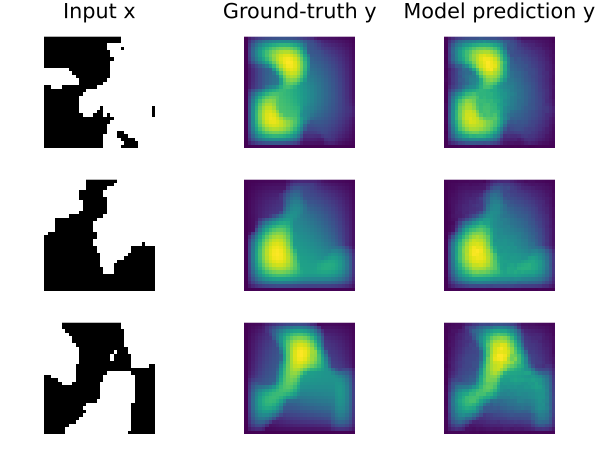

In [29]:
i = 1:3
inputs, ground_truth, predictions = x_test_32[:, :, :, i], y_test_32[:, :, :, i], pred[:, :, :, i]
fig = create_comparison_figure(inputs, ground_truth, predictions)

### Super-resolution

In [30]:
darcy_test_64 = torch.load("/p/tmp/alistair/TUM-Dynamics-Lecture/lectures/lecture-14/assets/darcy_test_64.pt", weights_only=true)
x_test_64, y_test_64 = process_torch_dataset(darcy_test_64);

In [31]:
x_test_64 = device(x_test_64)
pred = fno(x_test_64);

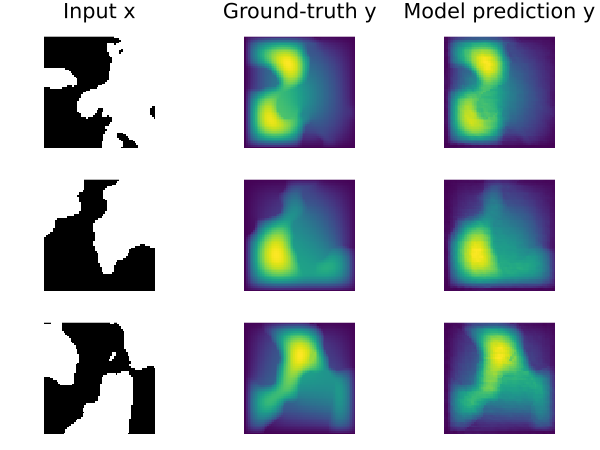

In [32]:
i = 1:3
inputs, ground_truth, predictions = x_test_64[:, :, :, i], y_test_64[:, :, :, i], pred[:, :, :, i]
fig = create_comparison_figure(inputs, ground_truth, predictions)

* That looks pretty good! Our model trained on 32x32 inputs generalizes well to 64x64.